# Ensemble Modeling To Enhance Click-Through Rate Prediction For Nigerian Online Marketing Campaigns


The project aims to develop a machine learning model for predicting the click-through rate (CTR) of advertisements. The dataset used in this project is sourced from Kaggle and includes the following features:

- **id**: Unique identifier for each advertisement.
- **click**: Binary indicator of whether the ad was clicked (1) or not clicked (0).
- **hour**: Timestamp in the format YYMMDDHH (e.g., 14091123 represents 23:00 on September 11, 2014, UTC).
- **C1**: Anonymized categorical variable.
- **banner_pos**: Position of the banner.
- **site_id**: Identifier for the website.
- **site_domain**: Domain of the website.
- **site_category**: Category of the website.
- **app_id**: Identifier for the application.
- **app_domain**: Domain of the application.
- **app_category**: Category of the application.
- **device_id**: Identifier for the device.
- **device_ip**: IP address of the device.
- **device_model**: Model of the device.
- **device_type**: Type of the device.
- **device_conn_type**: Connection type of the device.
- **C14-C21**: Additional anonymized categorical variables.


Observed Challenge with the dataset
* There is no explicit information on how the dataset was collected
* Features like C1, C14 to C21 represents anonymized variables in order to protect the data privacy. 

In [1]:
# import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, log_loss, roc_curve
import pickle
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')

The dataset contains over 40 million observations, which causes long loading times and suboptimal performance on my PC. An initial examination reveals a significant class imbalance: only about 17% of the observations correspond to clicked ads, while the remaining 83% are non-clicked ads. To address this imbalance, I used the `resample` class from the `sklearn` library to balance the dataset by matching the number of non-clicked ad observations to the number of clicked ad observations. This process reduced the dataset to approximately 13 million observations. I saved the balanced dataset as `balanced_df`. In this notebook, I have commented out the code for handling class imbalance and will start my analysis by loading the balanced dataset instead of the entire 40 million observations.

In [2]:
# load the whole dataset
# df = pd.read_csv('train/busola/train.csv')

In [3]:
def resample_data(frame):
    """
    Function to resample click and non click observations in the dataset to ensure 
    the number of click ad is similar to unclick ad.
    """
    # separate click and unclick ad
    clicked_df = frame[frame.click == 1]
    nonclicked_df = frame[frame.click == 0]

    # define the number of samples to be equal to the number of clicked observations
    n_samples = frame['click'].value_counts()[1]

    # sampling clicked observations
    clicked_df_sampled = resample(clicked_df,
                                  replace=False,    # sample with replacement
                                  n_samples=n_samples, # to match majority class
                                  random_state=42) # reproducible results

    # sampling non-clicked observations
    nonclicked_df_sampled = resample(nonclicked_df,
                                    replace=False,    # sample without replacement
                                    n_samples=n_samples, # to match minority class
                                    random_state=42) # reproducible results


    # Combine the dataset
    balanced_frame = pd.concat([clicked_df_sampled, nonclicked_df_sampled])
    
    return balanced_frame

# df = resample_data(df)

# # Save the balanced dataset
# df.to_csv('balanced_data.csv', index=False)

Having saved the balanced dataset, now, I will load the balanced dataset for my analysis

In [ ]:
#unzip the dataset
# path to the .zip file
zip_file_path = 'balanced_data.zip'  

# Open the .zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as file:
    file.extractall()

In [4]:
# load the balanced dataset`
df = pd.read_csv('balanced_data.csv')

In [5]:
df.shape

(13730132, 24)

In this project, there will be two approaches to see the impact of using large number of observations. 

#### Approach 1: 

In the first approach, the sampling method below will have a value of 100,000. Thus, the machine learning model will be trained and tested with a dataset with a total of 100,000 observations. 

#### Approach 2:

In the second approach, the 1,000,000 will be changed to 1,000,000 and then rerun the code to see the impact of increased number of observations on the model performance.

In [6]:
df = df.sample(1000000, random_state=50).reset_index(drop=True)

In [8]:
# overview the dataset
df.head(10)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.659816e+18,1,14102706,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22676,320,50,2616,0,35,-1,51
1,1.210188e+19,0,14102615,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,18093,320,50,2060,3,39,-1,23
2,1.292948e+19,1,14102317,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,22142,320,50,2550,0,547,-1,51
3,2.978956e+18,0,14103003,1005,0,85f751fd,c4e18dd6,50e219e0,f888bf4c,5b9c592b,...,1,0,21611,320,50,2480,3,297,100111,61
4,1.678281e+18,1,14102613,1005,0,d8bb8687,98e6755b,3e814130,ecad2386,7801e8d9,...,1,0,17239,320,50,1973,3,39,-1,23
5,1.509257e+19,0,14102911,1005,0,93eaba74,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,19015,300,250,2162,2,39,-1,33
6,7.180166e+18,1,14102300,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17262,320,50,1872,3,39,-1,23
7,1.107226e+19,0,14102215,1005,0,26fa1946,e2a5dc06,3e814130,ecad2386,7801e8d9,...,1,2,17239,320,50,1973,3,39,100148,23
8,7.997510e+18,1,14102608,1010,1,85f751fd,c4e18dd6,50e219e0,16c382c3,7801e8d9,...,4,2,20294,320,50,2325,3,801,-1,42
9,1.833276e+19,0,14102707,1005,0,fa2fd0b3,51d8d3b4,f028772b,ecad2386,7801e8d9,...,1,0,19772,320,50,2227,0,935,-1,48


The dataset does not contain any missing values. However, some features are not recorded in the correct format. For example, the date is recorded as 'hour' in the format YYMMDDHH, which represents the year, month, day, and hour. This format is not suitable for extracting time-based features. Therefore, I will rename the 'hour' column to 'date' and convert its values into a proper datetime format. Afterward, I will engineer additional time-based features and save them accordingly.

Also, the dataset contains 24 features, most of which are categorical. Some features have been anonymized and are encoded as 'C' variables. The value under each of the features has been encoded to maintain anonymousity. Also, the values under C features has been hashed to number. Subsequently, I will do Exploratory Data Analysis (EDA) to identify features that are important for click through rate prediction. For the features of interest, I will handle the encoded features as appropriate to a form the model can understand. 

The feaures in the dataset can be grouped to three, features about the ad posted which is the id and click, features about the platform where the ad is posted and when which are 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', and 'app_category' and features about the users which are 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type'. The C features are already anonymized. for this analysis, the C features and features about the users will be dropped. This is due to the fact that advertiser may not be able to know before hand who will be available online to see the ad but they can decide before hand where to post teh ad and when

In [9]:
# drop non relevant features
df = df.drop(columns=['C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C1'])

In [10]:
# convert the hour columns 
df['hour'] = df['hour'].astype(str)

# reformat the value 
df['hour'] = df['hour'].apply(lambda x: '20'+x[:2]+'-'+x[2:4]+'-'+x[4:6]+'-'+x[6:])

# change the date datatype to datetime
df['hour'] = pd.to_datetime(df['hour'])

# rename hour to date
df = df.rename(columns={"hour": "date"})

In [11]:
# engineer hour from the date column

# extract hour 
df['hour'] = df['date'].dt.hour

# extract day 
df['day'] = df['date'].dt.day

Since all the dataset are obtained within a single month and year, year and month are the same for all the observations. There is no need for year, month and day features. Only time has a wider variability and may only be the only relevant time-based feature. Thus, only hour when the ad is posted was engineered

In [12]:
df.head()

,id,click,date,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,hour,day
0,3.659816e+18,1,2014-10-27 06:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,da202424,6715887e,1,0,6,27
1,1.210188e+19,0,2014-10-26 15:00:00,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,7568cb14,375c3d47,1,0,15,26
2,1.292948e+19,1,2014-10-23 17:00:00,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e439066b,d1cbe61f,1,0,17,23
3,2.978956e+18,0,2014-10-30 03:00:00,0,85f751fd,c4e18dd6,50e219e0,f888bf4c,5b9c592b,0f2161f8,016919f6,ce9076c7,2cd8ff6d,1,0,3,30
4,1.678281e+18,1,2014-10-26 13:00:00,0,d8bb8687,98e6755b,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,e678cf11,1f0bc64f,1,0,13,26


### Define Functions


I will define all the functions I will use in the project under this section

In [13]:
def calculate_ctr(feature):
    """
    This function will calculate the click-through-rate observed for the ads 
    base on the feature of interest (feature)
    """
    # calculate the impression and click
    new_df = df.groupby(feature).agg({'click': ['count', 'sum']}).reset_index()
    
    # rename the columns
    new_df.columns = [feature, 'impression', 'click']
    
    # calculate the click through rate
    new_df['ctr'] = new_df['click']/new_df['impression'] * 100
    
    # sort in the descending order of impression
    new_df = new_df.sort_values(by='impression', ascending=False).reset_index(drop=True)
    
    return new_df

In [14]:
def plot_chart(feature):
    """
    This function plot the bar chart of the specified categorical feature 
    """
    # get the grouped dataframe 
    new_df = calculate_ctr(feature)
    
    # print the number of unique values
    print(f"There are {new_df[feature].nunique()} unique values in {feature}")
    
    # select max of top 15 base on impression
    new_df = new_df.head(10)
    
    # melt the dataframe
    melted_df = pd.melt(frame=new_df, id_vars = [feature, 'ctr'], var_name='metrics')
    

#     plt.figure(figsize=(10,10));
    sns.barplot(data=melted_df, x = feature, y = 'value', hue='metrics');
    plt.title(f"Distribution of Top {feature} Impression and Click Base Impression");
    plt.xticks(rotation=45);
    plt.legend(loc='lower left')


In [15]:
def train_and_predict(model):
    """
    Function that train the model and predict the test
    """
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions 
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    return model, y_pred, y_proba

In [16]:
def evaluate_prediction(predictions, y_proba, model_name):
    """
    Function that evaluates the performance of the model using 
    accuracy, F1_score, and AUC, and prints the confusion matrix.
    
    Parameters:
    predictions: array-like of shape (n_samples,)
        Predicted labels, as returned by a classifier.
    model_name: str
        Name of the model to be used in the plot titles.
    y_test: array-like of shape (n_samples,)
        True labels.
    y_proba: array-like of shape (n_samples,), optional (default=None)
        Probability estimates of the positive class. Required if AUC is to be calculated.
        
    Returns:
    model_accuracy: float
        Accuracy of the model.
    model_f1_score: float
        F1 score of the model.
    model_auc: float
        AUC score of the model.
    chart: sns.heatmap object
        Confusion matrix heatmap.
    """
    # Evaluate the model
    model_accuracy = accuracy_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate AUC if probability estimates are provided
    model_auc = roc_auc_score(y_test, y_proba)
    
    # Plot the confusion matrix
    chart = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # Plot the ROC AUC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {model_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return model_accuracy, model_f1_score, model_auc, chart

### Exploratory Data Analysis (EDA)

### Univariate Analysis

##### Hour of the day

There are 24 unique values in hour


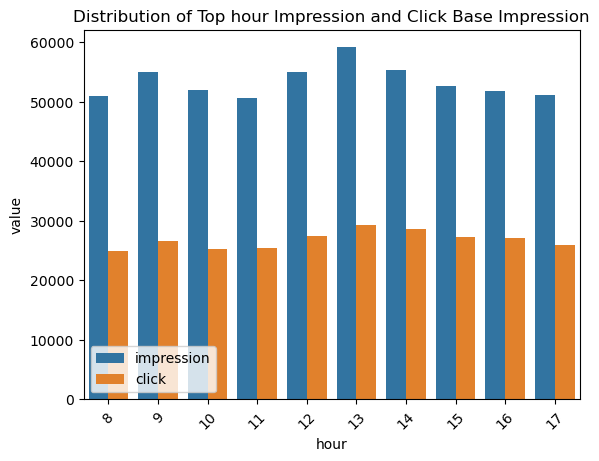

In [17]:
# check the distribution of hour
plot_chart('hour')

Most ads are posted between 5 AM and 5 PM, with the highest impressions occurring around 12 noon. Although the pattern isn't sharply distinct, ads are more likely to be clicked in the afternoon than in the morning.

In [18]:
b = df.groupby('hour', as_index=False)['click'].agg({'sum', 'count'})

In [19]:
b['ctr'] = b['sum']/b['count'] * 100

Text(0.5, 1.0, 'Click Through Rate Variation by Hour')

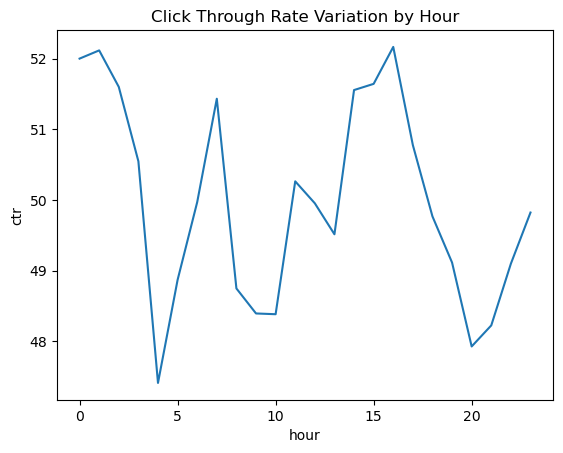

In [20]:
sns.lineplot(data=b, x='hour', y='ctr')
plt.title("Click Through Rate Variation by Hour")

There is no clear pattern on the variation of click through rate with the hour of the day. but from the above it is obvious that the click through rate isn't the same for all the hours. it is just that we can't just conclude that people tend to click on ad more in the morning compare to afternoon. but we can see the up and down trend of the CTR by hour which indicate hour may be a good predictor of CTR

### Banner_pos Variable

There are 7 unique values in banner_pos


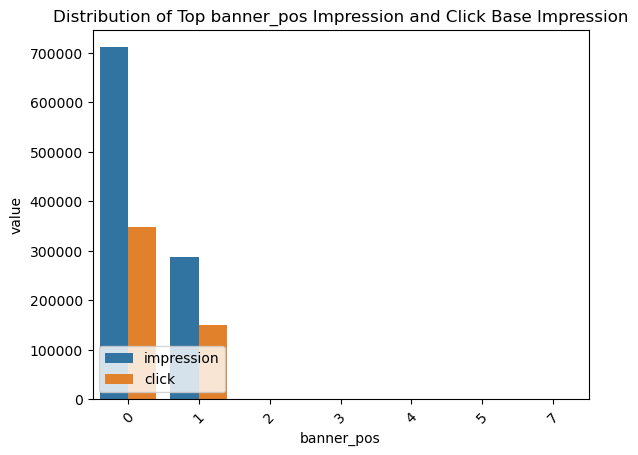

In [21]:
# check the distribution os banner_pos
plot_chart('banner_pos')

There are 7 unique values in banner_pos


Text(0, 0.5, 'Log Transformed Count')

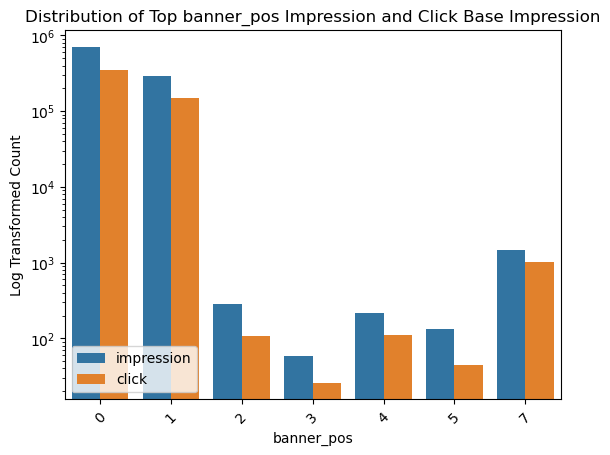

In [22]:
# check the distribution os banner_pos
plot_chart('banner_pos')
plt.yscale('log')
plt.ylabel('Log Transformed Count')

Two commonly used banner position for ad post are position 0 and 1. Position 0 has more impression and click than others. Thus, where the ad is located on the website is important for determining the success of the ad post

### Site_id variable

There are 2618 unique values in site_id


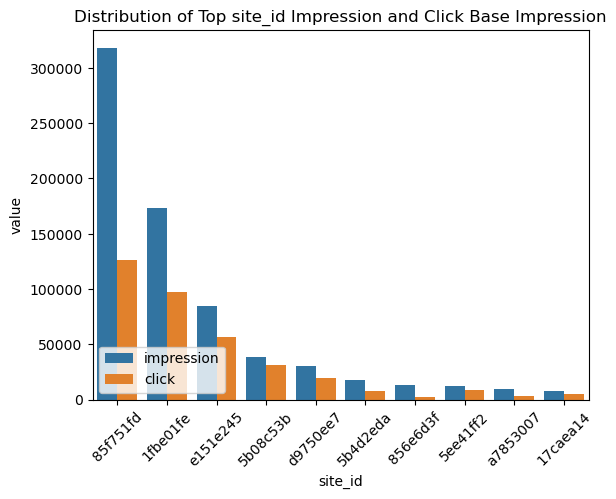

In [23]:
# check the distribution os site_id
plot_chart('site_id')

There are 2618 unique values in site_id


Text(0, 0.5, 'Log Transformed Count')

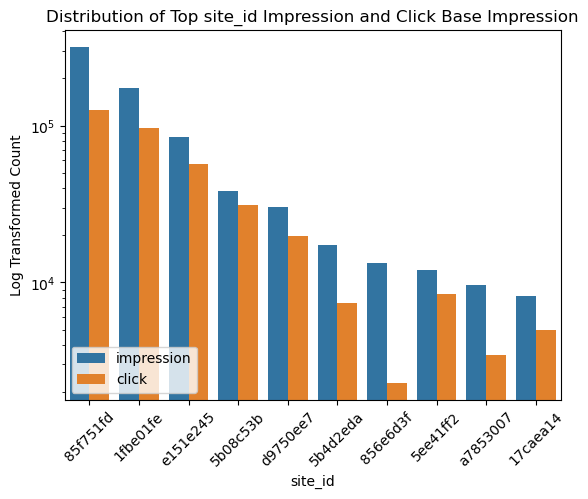

In [24]:
# check the distribution os site_id
plot_chart('site_id')
plt.yscale('log')
plt.ylabel('Log Transformed Count')

I expect the success of the ad post to be a factor of the site where the ad is displayed. There are 3519 different categories of site. Thus, there will be a need to merge some website with less frequent observations to reduce the spersity that may arise from one-hot encoding. Although, site id `1fbe01fe` has the second highest number of impression, it seems to have more click through rate that the first website base on the number of impression. 

### Device id

There are 145962 unique values in device_id


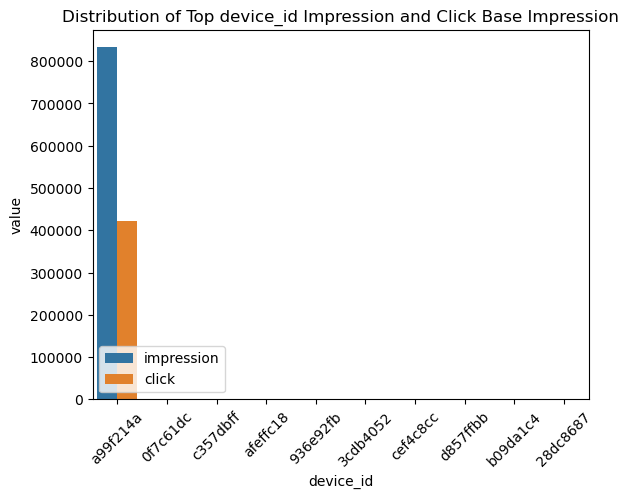

In [25]:
# check the distribution os device_id
plot_chart('device_id')

In [26]:
df['device_id'].value_counts()

device_id
a99f214a    832725
0f7c61dc      1264
c357dbff      1042
afeffc18       298
936e92fb       266
             ...  
8505f7cb         1
49746a6d         1
66a402a1         1
edc46a3c         1
96da893b         1
Name: count, Length: 145962, dtype: int64

In [27]:
df[df['device_id'] == 'a99f214a']['site_id'].value_counts()

site_id
85f751fd    202356
1fbe01fe    173619
e151e245     84757
5b08c53b     38194
d9750ee7     30124
             ...  
e4eb2141         1
8f6ae7ea         1
d35aa4c6         1
6f03c1b6         1
1e1e1e2f         1
Name: count, Length: 1335, dtype: int64

### Device ip

There are 559668 unique values in device_ip


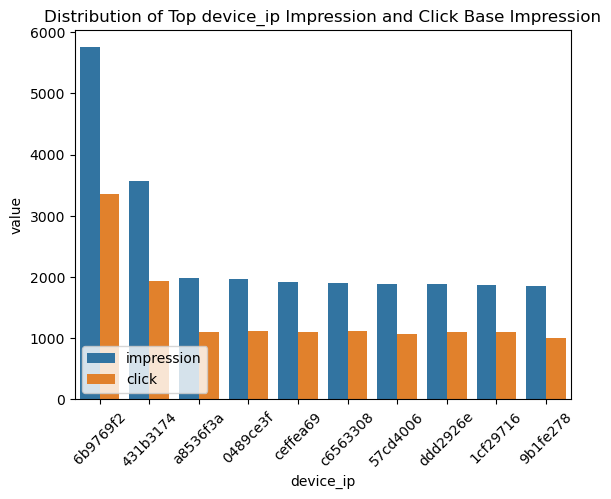

In [28]:
# check the distribution os device_ip
plot_chart('device_ip')

### Device Model

There are 5204 unique values in device_model


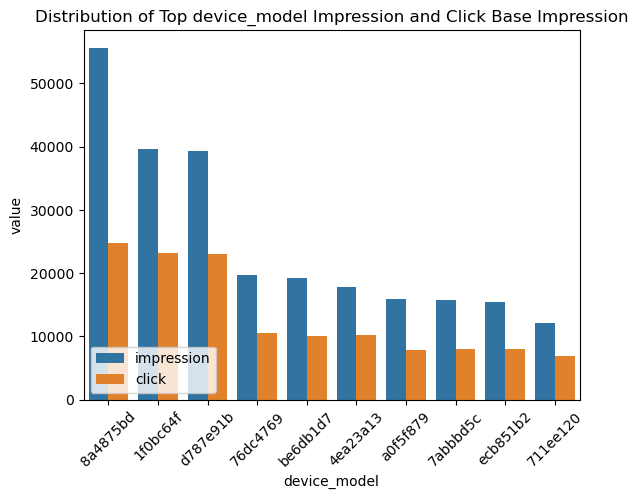

In [29]:
# check the distribution os device_model
plot_chart('device_model') 

### Device Type

There are 4 unique values in device_type


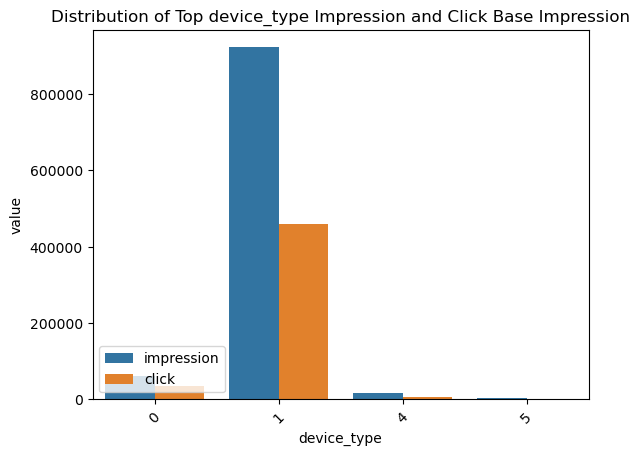

In [30]:
# check the distribution os device_type
plot_chart('device_type') 

### Device Conn Type

There are 4 unique values in device_conn_type


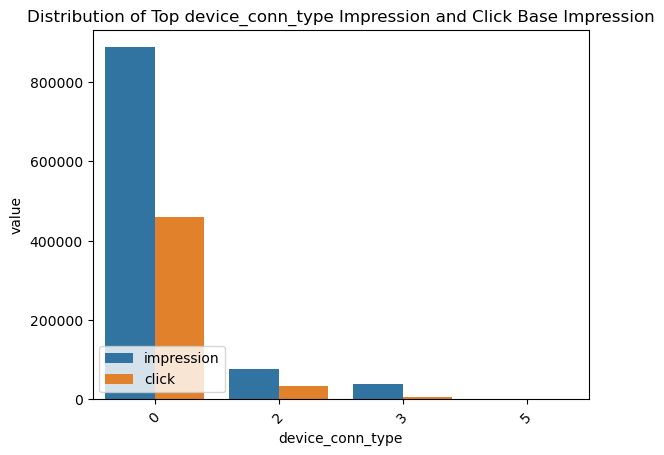

In [31]:
# check the distribution os device_conn_type
plot_chart('device_conn_type') 

### site_domain

There are 2830 unique values in site_domain


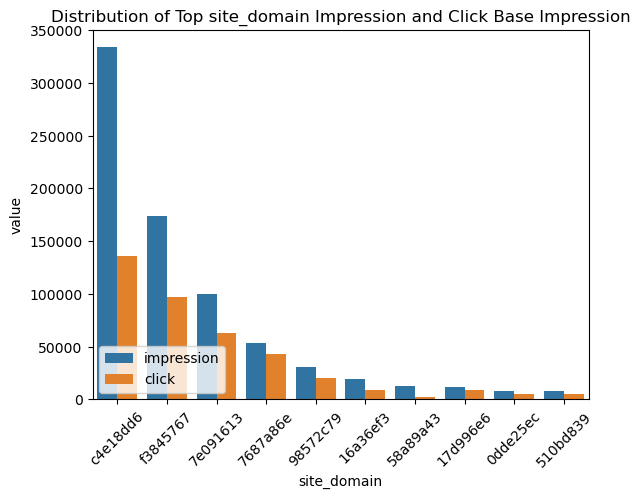

In [32]:
# check the distribution is site_domain
plot_chart('site_domain')

There are 2830 unique values in site_domain


Text(0, 0.5, 'Log Transformed Count')

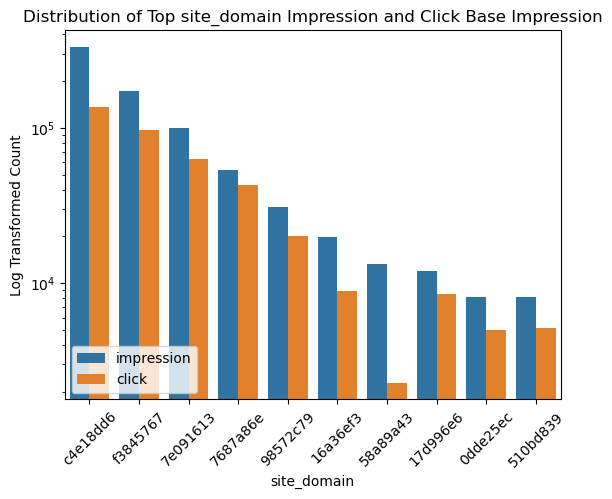

In [33]:
# check the distribution is site_domain
plot_chart('site_domain')
plt.yscale('log')
plt.ylabel('Log Transformed Count')

There seems to be a similar pattern between site_id and site_domain. Subsequently, I will check the correlation between the two variable to seem if the two variables explain the same information. If they, there is no need including the two in the analysis to prevent the occurence of multicollinearity

### Site_category Variable

There are 20 unique values in site_category


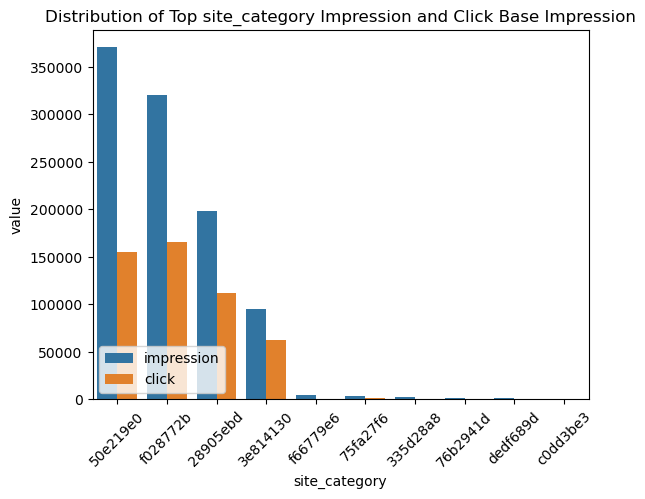

In [34]:
# check the distribution is site_category
plot_chart('site_category')

There are 20 unique values in site_category


Text(0, 0.5, 'Log Transformed Count')

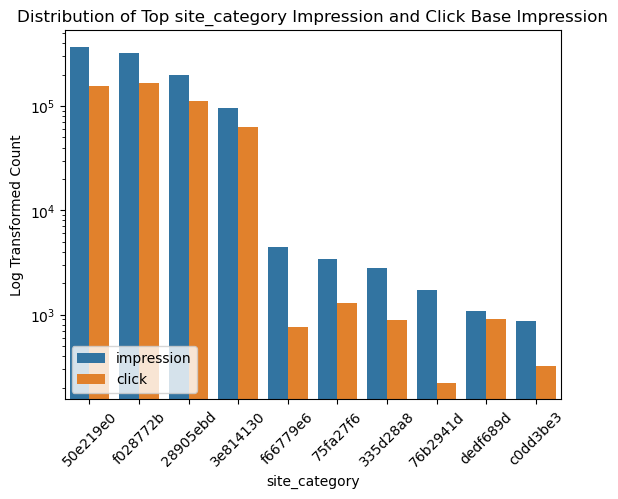

In [35]:
# check the distribution is site_category
plot_chart('site_category')
plt.yscale('log')
plt.ylabel('Log Transformed Count')

Only the top 4 site category have appreciable number of impression and click. Subsequently, I will merge the values with low frequency together to reduce the sparsity

### App_id

There are 3104 unique values in app_id


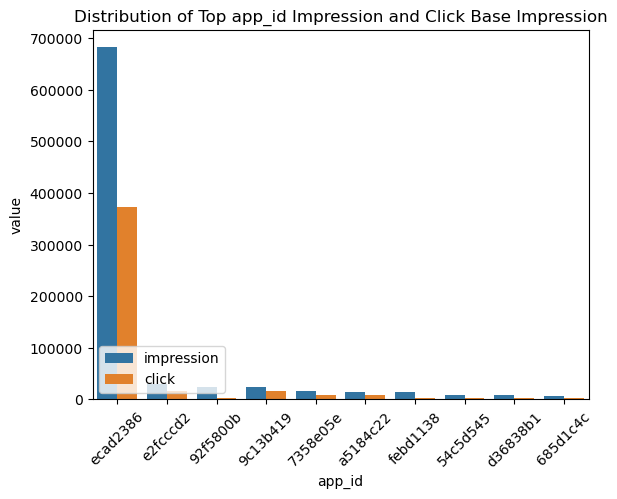

In [36]:
# check the distribution is app_id
plot_chart('app_id')

There are 3104 unique values in app_id


Text(0, 0.5, 'Log Transformed Count')

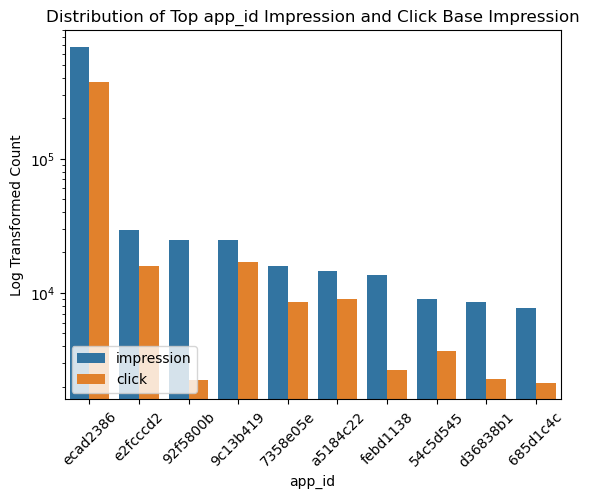

In [37]:
# check the distribution is app_id
plot_chart('app_id')
plt.yscale('log')
plt.ylabel('Log Transformed Count')

The pattern of distribution is nearly similar among all the app_id except for the first observation. App_id uniquely identify the name of the app where the ad is posted. It seems the ad in this dataset get significantly high number of impression in one app out of the total 5413 apps available.

### app_domain Variable

There are 181 unique values in app_domain


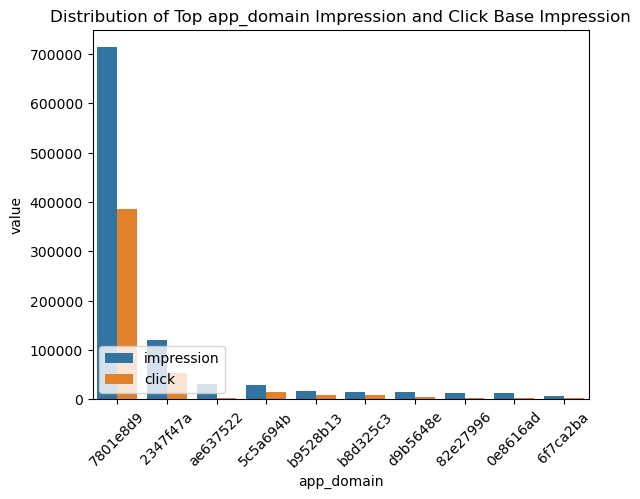

In [38]:
# check the distribution is app_domain
plot_chart('app_domain')

There are 181 unique values in app_domain


Text(0, 0.5, 'Log Transformed Count')

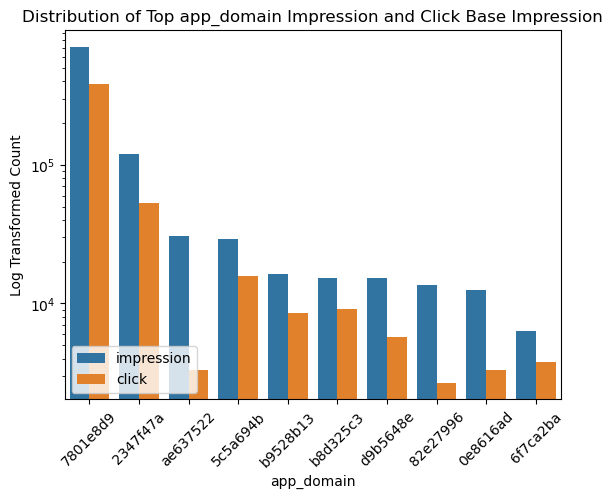

In [39]:
# check the distribution is app_domain
plot_chart('app_domain')
plt.yscale('log')
plt.ylabel('Log Transformed Count')

In [40]:
df.columns

Index(['id', 'click', 'date', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'hour',
       'day'],
      dtype='object')

### Data Preprocessing

From the insights above, for features with too many categories such as 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', and 'app_category', we will only take the top 10 category and convert the remaining categories to others. This will help us to many high dimension that may result from one-hot encoding. 

In [41]:
df

,id,click,date,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,hour,day
0,3.659816e+18,1,2014-10-27 06:00:00,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,da202424,6715887e,1,0,6,27
1,1.210188e+19,0,2014-10-26 15:00:00,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,7568cb14,375c3d47,1,0,15,26
2,1.292948e+19,1,2014-10-23 17:00:00,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e439066b,d1cbe61f,1,0,17,23
3,2.978956e+18,0,2014-10-30 03:00:00,0,85f751fd,c4e18dd6,50e219e0,f888bf4c,5b9c592b,0f2161f8,016919f6,ce9076c7,2cd8ff6d,1,0,3,30
4,1.678281e+18,1,2014-10-26 13:00:00,0,d8bb8687,98e6755b,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,e678cf11,1f0bc64f,1,0,13,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.204516e+17,0,2014-10-28 16:00:00,0,85f751fd,c4e18dd6,50e219e0,73206397,2347f47a,8ded1f7a,96da893b,3a45b855,fa61e8fe,1,0,16,28
999996,1.592010e+19,1,2014-10-22 11:00:00,1,88154ade,9f448720,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,d3e7991b,c27704fd,1,0,11,22
999997,6.309999e+17,1,2014-10-29 00:00:00,0,203b00f1,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,0f7c61dc,e78deba7,373ecbe6,0,0,0,29
999998,1.320441e+19,1,2014-10-29 09:00:00,0,4bf5bbe2,6b560cc1,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b7df2243,158e4944,1,0,9,29


In [42]:
# convert banner position datatye to string
df['banner_pos'] = df['banner_pos'].astype(str)

# define the categorical variables to hash
categorical_features = ['site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'banner_pos',
                       'device_id','device_ip', 'device_model', 'device_type', 'device_conn_type']

# hash categorical_features 
hashed_df = df[categorical_features].applymap(lambda x: hash(x))

# drop on unhashed features in df and concat it with the hashed_df 
full_df = pd.concat([df.drop(columns=categorical_features), hashed_df], axis=1)

In [43]:
full_df.shape

(1000000, 17)

In [44]:
full_df

,id,click,date,hour,day,site_id,site_domain,site_category,app_id,app_domain,app_category,banner_pos,device_id,device_ip,device_model,device_type,device_conn_type
0,3.659816e+18,1,2014-10-27 06:00:00,6,27,3665487526838884087,7824116579371946374,-3857955006356517461,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-1039711748619668568,3840366682804991154,-1812128747875242556,1,0
1,1.210188e+19,0,2014-10-26 15:00:00,15,26,4879473048852659648,1838422630595594534,-2561539986443362888,1590507227074259408,3570217178519172890,7607000065247905174,-5310980289592503253,-1039711748619668568,-3313877460173168513,2619198112823318926,1,0
2,1.292948e+19,1,2014-10-23 17:00:00,17,23,2409727628848734679,-2085495281661558479,-2561539986443362888,1590507227074259408,3570217178519172890,7607000065247905174,-5310980289592503253,-1039711748619668568,-778805621788049491,-5994743170234408168,1,0
3,2.978956e+18,0,2014-10-30 03:00:00,3,30,2385427900992208210,-8676013339311015755,7161739892603298274,-3688261001443210606,-1660805451130964211,6036243111916665715,2705770679656110264,7737616269279377884,-6370815478674806319,-1233073629911043591,1,0
4,1.678281e+18,1,2014-10-26 13:00:00,13,26,-1116999680913929115,-1070741719237064277,2288744711155142683,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-1039711748619668568,8193122643758464112,-919414302979884367,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.204516e+17,0,2014-10-28 16:00:00,16,28,2385427900992208210,-8676013339311015755,7161739892603298274,-4163429202213497992,-8157412732944032315,-3550717536879515815,2705770679656110264,-4665435856964978987,2247153141500073883,3015446416371207015,1,0
999996,1.592010e+19,1,2014-10-22 11:00:00,11,22,5760573304832053219,-6486416169653379319,2288744711155142683,1590507227074259408,3570217178519172890,7607000065247905174,-5310980289592503253,-1039711748619668568,2798650468921380348,6096746542657829790,1,0
999997,6.309999e+17,1,2014-10-29 00:00:00,0,29,1431053193580015102,-8676013339311015755,7161739892603298274,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-2479454775307263816,4795051340021384671,-8898014846370119884,0,0
999998,1.320441e+19,1,2014-10-29 09:00:00,9,29,-9117781183835057167,-6349224366086897277,-3857955006356517461,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-1039711748619668568,6850120172254563950,7550851283014736668,1,0


In [45]:
df.columns

Index(['id', 'click', 'date', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'hour',
       'day'],
      dtype='object')

In [46]:
df.shape

(1000000, 17)

In [47]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   id                1000000 non-null  float64       
 1   click             1000000 non-null  int64         
 2   date              1000000 non-null  datetime64[ns]
 3   hour              1000000 non-null  int32         
 4   day               1000000 non-null  int32         
 5   site_id           1000000 non-null  int64         
 6   site_domain       1000000 non-null  int64         
 7   site_category     1000000 non-null  int64         
 8   app_id            1000000 non-null  int64         
 9   app_domain        1000000 non-null  int64         
 10  app_category      1000000 non-null  int64         
 11  banner_pos        1000000 non-null  int64         
 12  device_id         1000000 non-null  int64         
 13  device_ip         1000000 non-null  int64  

In [48]:
# split the dataset to predictor (X) and response (y)

X = full_df.drop(columns=['id', 'date', 'click'])
y = full_df['click']

In [49]:
X

,hour,day,site_id,site_domain,site_category,app_id,app_domain,app_category,banner_pos,device_id,device_ip,device_model,device_type,device_conn_type
0,6,27,3665487526838884087,7824116579371946374,-3857955006356517461,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-1039711748619668568,3840366682804991154,-1812128747875242556,1,0
1,15,26,4879473048852659648,1838422630595594534,-2561539986443362888,1590507227074259408,3570217178519172890,7607000065247905174,-5310980289592503253,-1039711748619668568,-3313877460173168513,2619198112823318926,1,0
2,17,23,2409727628848734679,-2085495281661558479,-2561539986443362888,1590507227074259408,3570217178519172890,7607000065247905174,-5310980289592503253,-1039711748619668568,-778805621788049491,-5994743170234408168,1,0
3,3,30,2385427900992208210,-8676013339311015755,7161739892603298274,-3688261001443210606,-1660805451130964211,6036243111916665715,2705770679656110264,7737616269279377884,-6370815478674806319,-1233073629911043591,1,0
4,13,26,-1116999680913929115,-1070741719237064277,2288744711155142683,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-1039711748619668568,8193122643758464112,-919414302979884367,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,16,28,2385427900992208210,-8676013339311015755,7161739892603298274,-4163429202213497992,-8157412732944032315,-3550717536879515815,2705770679656110264,-4665435856964978987,2247153141500073883,3015446416371207015,1,0
999996,11,22,5760573304832053219,-6486416169653379319,2288744711155142683,1590507227074259408,3570217178519172890,7607000065247905174,-5310980289592503253,-1039711748619668568,2798650468921380348,6096746542657829790,1,0
999997,0,29,1431053193580015102,-8676013339311015755,7161739892603298274,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-2479454775307263816,4795051340021384671,-8898014846370119884,0,0
999998,9,29,-9117781183835057167,-6349224366086897277,-3857955006356517461,1590507227074259408,3570217178519172890,7607000065247905174,2705770679656110264,-1039711748619668568,6850120172254563950,7550851283014736668,1,0


In [50]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it
scaler.fit(X_train)

# transform train
X_train_scaled = scaler.transform(X_train)

# transform test
X_test_scaled = scaler.transform(X_test)

In [52]:
pd.DataFrame(X_test_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.550667,1.202758,-1.073979,-1.065238,-1.699977,0.269309,0.407663,0.374522,-1.565081,-0.073817,0.903903,-0.121036,0.004822,-0.349443
1,0.960447,-0.829895,0.442511,1.356073,-1.062506,0.269309,0.407663,0.374522,0.637136,-0.073817,-0.751682,-1.570503,0.004822,-0.349443
2,-0.550667,1.541533,0.154987,0.614523,-0.794680,0.269309,0.407663,0.374522,-1.565081,-0.073817,1.206747,0.232533,0.004822,-0.349443
3,0.288841,-1.168670,0.104154,-1.097107,1.214055,-2.346909,0.234685,0.091609,0.637136,-0.073817,0.874798,-1.116995,0.004822,-0.349443
4,-0.214864,-1.168670,0.104154,-1.097107,1.214055,1.256383,0.407663,-0.080626,-1.565081,3.025437,1.270109,-0.039800,6.050756,-0.349443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-1.725977,1.541533,1.614722,1.110146,1.214055,0.269309,0.407663,0.374522,0.637136,3.548021,1.103255,0.718271,-2.010489,-0.349443
299996,1.799954,0.525207,0.104154,-1.097107,1.214055,-2.166406,-2.138174,-2.858581,0.637136,-0.073817,1.490373,-0.855905,0.004822,-0.349443
299997,-0.886470,1.541533,0.442511,1.356073,-1.062506,0.269309,0.407663,0.374522,0.637136,-0.073817,-0.641070,-0.676883,0.004822,-0.349443
299998,-0.718568,-0.829895,0.763403,0.466142,-0.794680,0.269309,0.407663,0.374522,-1.565081,-0.073817,-1.410024,-1.184992,0.004822,-0.349443


### Modeling

### Train and Evaluate the models

In [54]:
# define a variable to collect models' score
model_eval = []

### Logistic Regression

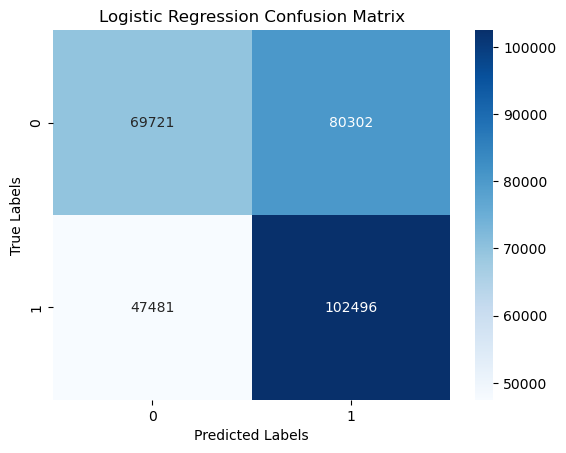

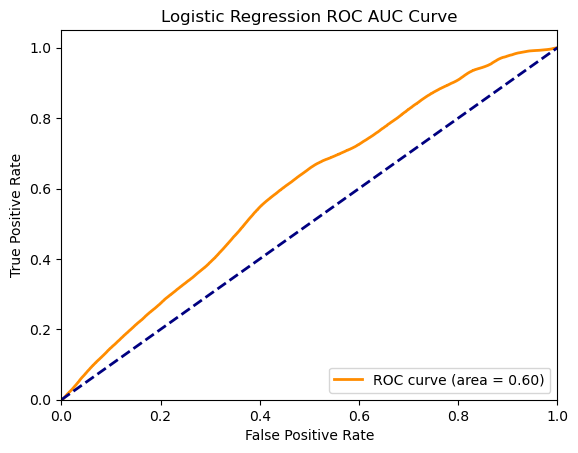

Logistic Regression Accuracy: 0.5740566666666667
Logistic Regression F1_score: 0.6160078130869205
Logistic Regression AUC: 0.5961853115947569


<Figure size 640x480 with 0 Axes>

In [55]:
# train and predict logistic regression model
lr_model, y_pred, y_proba = train_and_predict(model=LogisticRegression(C=0.01, l1_ratio=0.0, max_iter=100, penalty='l1', solver='liblinear'))

# Evaluate Logistic Regression model
model_accuracy, model_f1_score, model_auc, _ = evaluate_prediction(y_pred, y_proba, "Logistic Regression")

model_eval.append({'model': 'logistic regression',
                  'accuracy': model_accuracy,
                  'f1_score': model_f1_score,
                  'AUC': model_auc
                  })

print(f"Logistic Regression Accuracy: {model_accuracy}")
print(f"Logistic Regression F1_score: {model_f1_score}")
print(f"Logistic Regression AUC: {model_auc}")

# Save the plot as a PNG file
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### Decision Tree

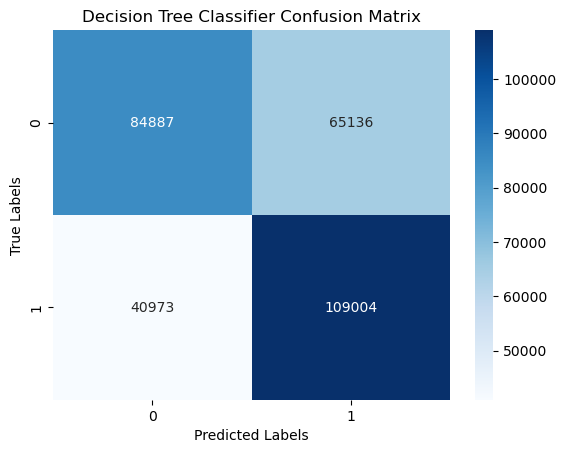

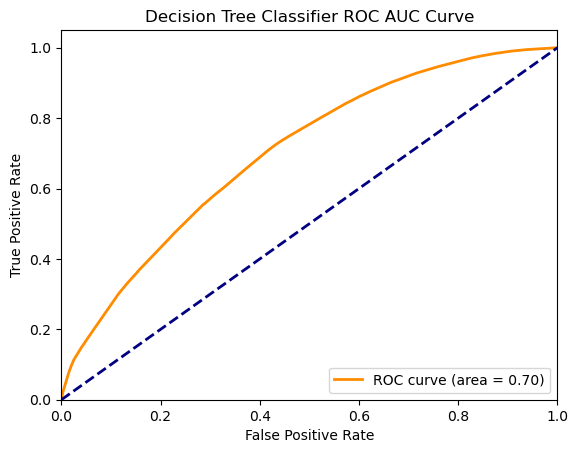

Decision Tree Classifier Accuracy: 0.6463033333333333
Decision Tree Classifier F1_score: 0.6726213065035157
Decision Tree Classifier AUC: 0.7018475752789941


In [56]:
# train and predict Decision Tree Classifier 
dt_model, y_pred, y_proba = train_and_predict(model=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5, splitter='random', random_state=50))

# Evaluate Decision Tree Classifier 
model_accuracy, model_f1_score, model_auc, _ = evaluate_prediction(y_pred, y_proba, "Decision Tree Classifier")

model_eval.append({'model': 'decision tree',
                  'accuracy': model_accuracy,
                  'f1_score': model_f1_score,
                  'AUC': model_auc
                  })

print(f"Decision Tree Classifier Accuracy: {model_accuracy}")
print(f"Decision Tree Classifier F1_score: {model_f1_score}")
print(f"Decision Tree Classifier AUC: {model_auc}")

### Random Forest

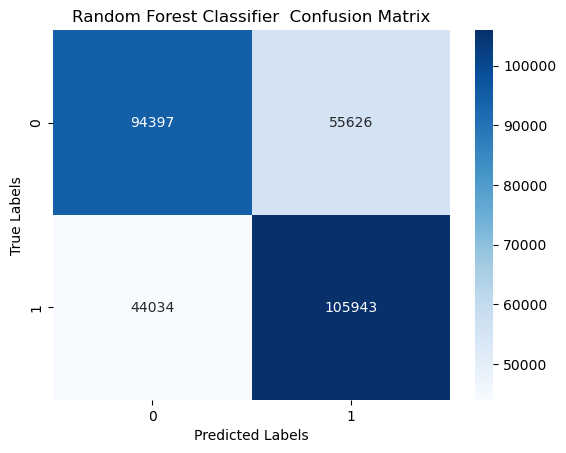

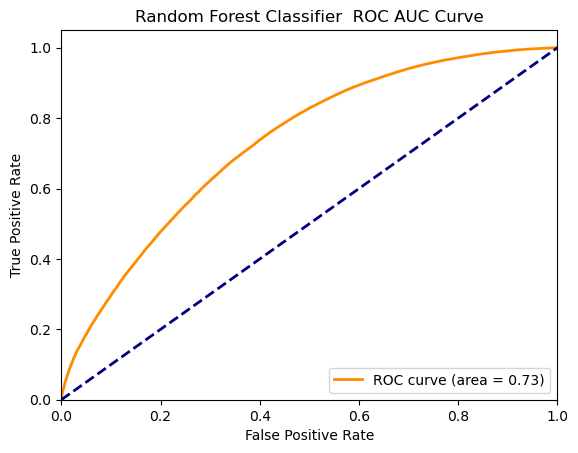

Random Forest Classifier  Accuracy: 0.6678
Random Forest Classifier  F1_score: 0.6801114442169054
Random Forest Classifier AUC: 0.7304938006636099


In [57]:
# train and predict Random Forest Classifier 
rf_model, y_pred, y_proba = train_and_predict(model=RandomForestClassifier(n_estimators=100, class_weight='balanced', criterion='gini', max_depth=40, max_features='log2', min_samples_leaf=4, min_samples_split=5, bootstrap=False,  random_state=42))

# Evaluate Random Forest Classifier 
model_accuracy, model_f1_score,model_auc, _ = evaluate_prediction(y_pred, y_proba, "Random Forest Classifier ")

model_eval.append({'model': 'random forest',
                  'accuracy': model_accuracy,
                  'f1_score': model_f1_score,
                  'AUC': model_auc
                  })

print(f"Random Forest Classifier  Accuracy: {model_accuracy}")
print(f"Random Forest Classifier  F1_score: {model_f1_score}")
print(f"Random Forest Classifier AUC: {model_auc}")

### Bernoulli Naive Bayes model

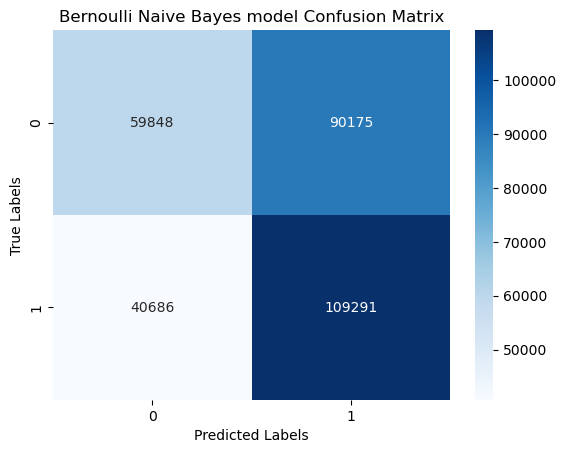

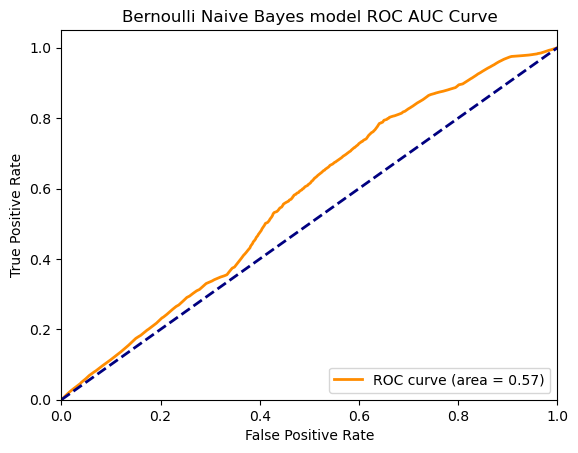

Bernoulli Naive Bayes model Accuracy: 0.5637966666666666
Bernoulli Naive Bayes model F1_score: 0.625515463179975
Bernoulli Naive Bayes model AUC: 0.5693735770532722


In [58]:
# train and predict Bernoulli Naive Bayes model
bnb_model, y_pred, y_proba = train_and_predict(BernoulliNB(alpha=0.01, binarize=0.0, fit_prior=False))

# Evaluate Bernoulli Naive Bayes model
model_accuracy, model_f1_score, model_auc, _ = evaluate_prediction(y_pred, y_proba, "Bernoulli Naive Bayes model")

model_eval.append({'model': 'Bernoulli Naive Bayes model',
                  'accuracy': model_accuracy,
                  'f1_score': model_f1_score,
                  'AUC': model_auc
                  })

print(f"Bernoulli Naive Bayes model Accuracy: {model_accuracy}")
print(f"Bernoulli Naive Bayes model F1_score: {model_f1_score}")
print(f"Bernoulli Naive Bayes model AUC: {model_auc}")

### Esemble the models

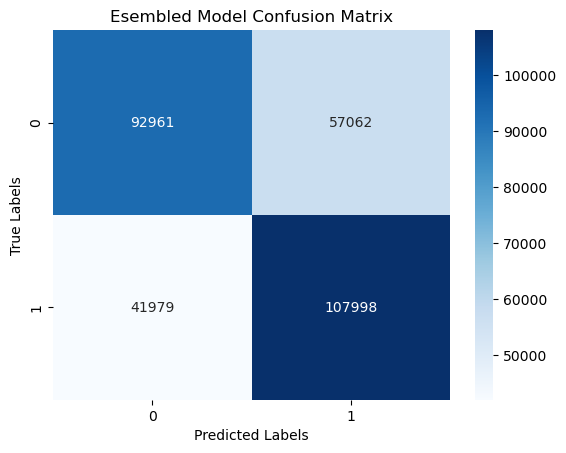

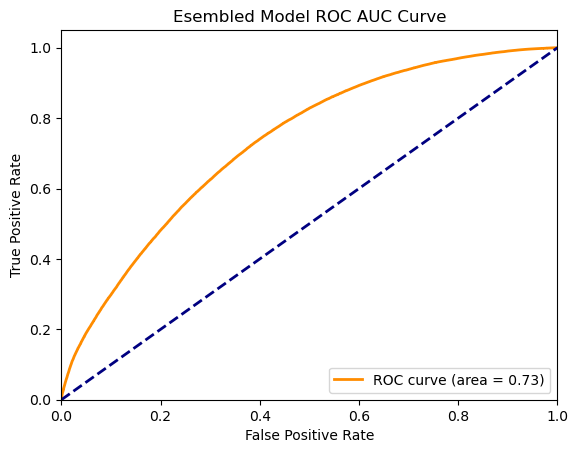

Ensembled Model Accuracy: 0.6698633333333334
Ensembled Model F1_score: 0.6856210540349229
Ensembled Model AUC: 0.731215807280585


In [59]:
# Create the Voting Classifier ensemble
# iterate over all the weights for the best combination
# 'weights': [
#         [1, 1, 1, 1], 0.69
#         [0.5, 1, 2, 2.5], 0.71
#         [0, 1, 2, 0] 0.68
#         [1, 2, 2, 2], 0.69
#         [0.5, 1.5, 2, 2.5], 0.71
#         [0, 0, 2, 2.5] 0.72
#         [0, 0, 3, 4], 0.72
#         

# Assign weights to models 
weights = [0, 0, 3, 4]

# train and predict with esemble model
esm_model, y_pred, y_proba = train_and_predict(VotingClassifier(
                        estimators=[
                            ('lr', lr_model), 
                            ('bnb', bnb_model), 
                            ('dt', dt_model), 
                            ('rf', rf_model)
                        ], 
                        voting='soft',  # 'soft' for probability-based voting, 'hard' for majority voting
                        weights=weights
                    ))

# Evaluate esemble model
model_accuracy, model_f1_score, model_auc, _ = evaluate_prediction(y_pred, y_proba, "Esembled Model")

model_eval.append({'model': 'Esembled Model',
                  'accuracy': model_accuracy,
                  'f1_score': model_f1_score,
                  'AUC': model_auc
                  })

print(f"Ensembled Model Accuracy: {model_accuracy}")
print(f"Ensembled Model F1_score: {model_f1_score}")
print(f"Ensembled Model AUC: {model_auc}")

In [61]:
pd.DataFrame(model_eval)

,model,accuracy,f1_score,AUC
0,logistic regression,0.574057,0.616008,0.596185
1,decision tree,0.646303,0.672621,0.701848
2,random forest,0.667800,0.680111,0.730494
3,Bernoulli Naive Bayes model,0.563797,0.625515,0.569374
4,Esembled Model,0.669863,0.685621,0.731216


In [62]:
pd.DataFrame(model_eval)

,model,accuracy,f1_score,AUC
0,logistic regression,0.574057,0.616008,0.596185
1,decision tree,0.646303,0.672621,0.701848
2,random forest,0.667800,0.680111,0.730494
3,Bernoulli Naive Bayes model,0.563797,0.625515,0.569374
4,Esembled Model,0.669863,0.685621,0.731216


### Discussion

The result with 1,000,000 observations above indicate a better perform of the model when the number of observations are increased. To compare the result of the data with 1,000,000 observations with that of 100,000 observations, follow the instruction under the approach 1 above. 


It is observed that the performance of the logistic regression model shows a marginal improvement in accuracy (from 0.580000 to 0.0.596185) and F1 score (from 0.615572 to 0.0.616008) with the increased dataset size. However, the ROC AUC slightly decreased from 0.613841 in Figure 15 to 0.606735. This slight decrease in AUC may indicate that while logistic regression can better fit the larger dataset, it still struggles to capture the more complex relationships inherent in the data.


However, the decision tree model improves all metrics with the larger dataset, particularly in the F1 score (from 0.654968 to 0.0.672621) and AUC (from 0.696693 to 0.701848). The accuracy also increased slightly. The decision tree, a nonlinear model, benefits from more data, which allows it to create more accurate splits and better capture complex patterns. However, decision trees are prone to overfitting, and the slight improvements suggest that while the model became more accurate, it might still overfit the data slightly, limiting the extent of performance gains.


Furthermore, the Random Forest's performance improved across all metrics with more data. It was observed that the accuracy increased from 0.659067 to 0.0.667800, the F1 score from 0.671674 to 0.680111, and the AUC from 0.716731 to 0.730494. Random Forest, an ensemble of decision trees, effectively reduces overfitting and leverages more data to build more robust and more generalised models. The larger dataset helped the model create better individual trees, leading to a more accurate and robust ensemble. The increase in AUC suggests that Random Forest's ability to distinguish between classes improved with more data, reinforcing its effectiveness in this task.

However, the Bernoulli Naive Bayes showed slight improvements in accuracy (from 0.562100 to 0.567427) and F1 score (from 0.622229 to 0.630937) but a decrease in AUC (from 0.593244 to 0.0.563797). This suggests that while the model's overall performance saw minor gains, its ability to distinguish between positive and negative classes might have slightly deteriorated. The Naive Bayes model relies heavily on the assumption of feature independence, which may not hold in a larger dataset with more complex interdependencies, hence the mixed results.


Finally, the ensemble model combines the strengths of individual models in approach 2. The metrics showed that the ensemble method outperformed other models, as evident with the accuracy score of 0.669863, F1 score of 0.685621, and AUC score of 0.731216. The ensemble's ability to aggregate predictions from multiple models makes it more robust, and the larger dataset provides more information for each model to learn from, leading to better generalisation. The increase in AUC, in particular, highlights the ensemble's enhanced ability to distinguish between classes with more data.pe.


### Save models

In [63]:
# create models directory
mkdir models

# pickel scaler
with open('models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# pickel ensemble model
with open('models/esm_model.pkl', 'wb') as file:
    pickle.dump(esm_model, file)